# get stimuli timestamp

In [1]:
# This example imports functions from the DemoReadSGLXData module to read
# analog data and convert it to volts based on the metadata information.
# The metadata file must be present in the same directory as the binary file.
# Works with both imec and nidq analog channels.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tkinter import Tk
from tkinter import filedialog
from DemoReadSGLXData.readSGLX import readMeta, SampRate, makeMemMapRaw, GainCorrectIM, GainCorrectNI, ChanGainsIM
from toolbox_ap_process import filter_signal

In [2]:
# Get bin file from user
root = Tk()         # create the Tkinter widget
root.withdraw()     # hide the Tkinter root window


binFullPath = Path('Z:/data/0_collaboration/ceph_phys/GLC5843/ceph_5843_1_g0/ceph_5843_1_g0_imec0/ceph_5843_1_g0_t0.imec0.lf.bin')

root.destroy()

meta = readMeta(binFullPath)
sRate = SampRate(meta)

In [3]:
import mat73

stim_mat = mat73.loadmat('./data/ttl_stim_cam.mat')
stimuli_duration = 1
sRate_ttl = 30000
start_idx = np.min(np.where(stim_mat['ttl'][0,:]>20000)[0])-int(sRate_ttl)
ttl_frame = stim_mat['ttl'][0,start_idx:int(start_idx+520*sRate_ttl)] # a rough frame that contains all grating patch
ttl_stim = np.where(ttl_frame>20000,30000,0)# ugly way to denoise the frame
stimuli_ontid = np.where(np.diff(ttl_stim)==30000)[0][12:]+1+start_idx
stimuli_offtid = stimuli_ontid+sRate_ttl*stimuli_duration

T_before_onset = 5
T_after_offset = 5

tStart =  stimuli_ontid[0]/sRate_ttl - T_before_onset
tEnd = stimuli_offtid[-1]/sRate_ttl + T_after_offset

ttl_target_stim = ttl_stim[int(tStart*sRate_ttl - start_idx):int(tEnd*sRate_ttl - start_idx)]

tID_stim_on = (stimuli_ontid - stimuli_ontid[0] + sRate_ttl*T_before_onset).astype(int)
tID_stim_off = (stimuli_offtid - stimuli_ontid[0] + sRate_ttl*T_before_onset).astype(int)

tStimOnset = tID_stim_on/sRate_ttl
tStimOffset = tID_stim_off/sRate_ttl


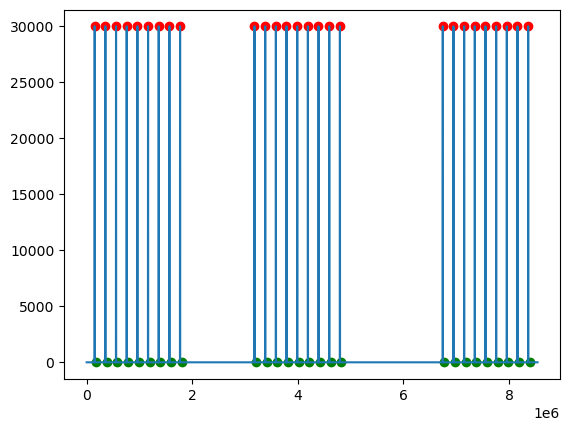

In [4]:
## crop the stimuli frame: we only care about what happened (1s before onset~1s after all stimuli delivered)  
plt.plot(ttl_target_stim)
plt.scatter(tID_stim_on, ttl_target_stim[tID_stim_on],color='red')
plt.scatter(tID_stim_off, ttl_target_stim[tID_stim_off],color='green')

In [5]:
plt.close('all')

# load raw data (neuropixel)

In [4]:
# Other parameters about what data to read
## only use the frame we plotted
#tStart = (stimuli_ontid[0] + start_idx - sRate)/sRate        # in seconds
#tEnd = (stimuli_offtid[-1] + start_idx + sRate)/sRate 
chanList = np.arange(80,120)    # list of channels to extract, by index in saved file

In [5]:
firstSamp = int(sRate*tStart)
lastSamp = int(sRate*tEnd)
rawData = makeMemMapRaw(binFullPath, meta)
selectData = rawData[chanList, firstSamp:lastSamp+1]


nChan: 385, nFileSamp: 13928864


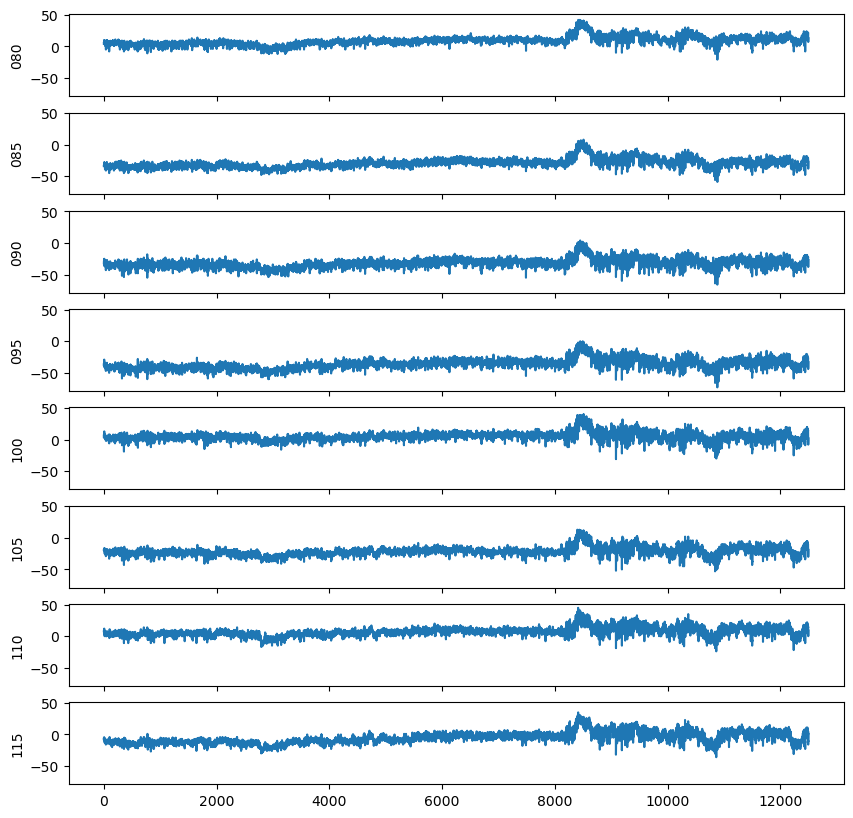

In [8]:
sample_interval = 5
fig, axes = plt.subplots(nrows=int(len(selectData)/sample_interval),ncols=1,sharex=True, sharey=True, figsize = (10,10))
for i,chanid in enumerate(np.arange(0,len(selectData),sample_interval)):
    axes[i].plot(selectData[chanid][int(15*sRate):int(20*sRate)])
    axes[i].set_ylabel('%03d'%(chanid+80))
    # axes[i].set_xticks(np.arange(0,5,5)*sRate,np.arange(0,25,5))
# plt.savefig('rawData_timeframe_lfp.png')

In [49]:

if meta['typeThis'] == 'imec':
    # apply gain correction and convert to uV
    a,convData = 1e6*GainCorrectIM(selectData, chanList, meta)
else:
    # apply gain correction and convert to mV
    convData = 1e3*GainCorrectNI(selectData, chanList, meta)

array([[ 89.0625,  93.75  ,  84.375 , ..., 196.875 , 196.875 , 187.5   ],
       [-79.6875, -75.    , -75.    , ...,  14.0625,  18.75  ,  14.0625],
       [ 51.5625,  46.875 ,  46.875 , ..., 182.8125, 178.125 , 182.8125],
       ...,
       [ 28.125 ,  37.5   ,  32.8125, ..., 225.    , 210.9375, 206.25  ],
       [ 84.375 ,  89.0625,  79.6875, ..., 614.0625, 618.75  , 618.75  ],
       [ -9.375 ,  -9.375 , -23.4375, ..., 243.75  , 243.75  , 239.0625]])

In [44]:
convData = np.where(np.abs(convData)>200,0,convData)

In [45]:
print('first samp %d'%firstSamp)
print('start time %.2f s'%tStart)

first samp 9529109
start time 3811.64 s


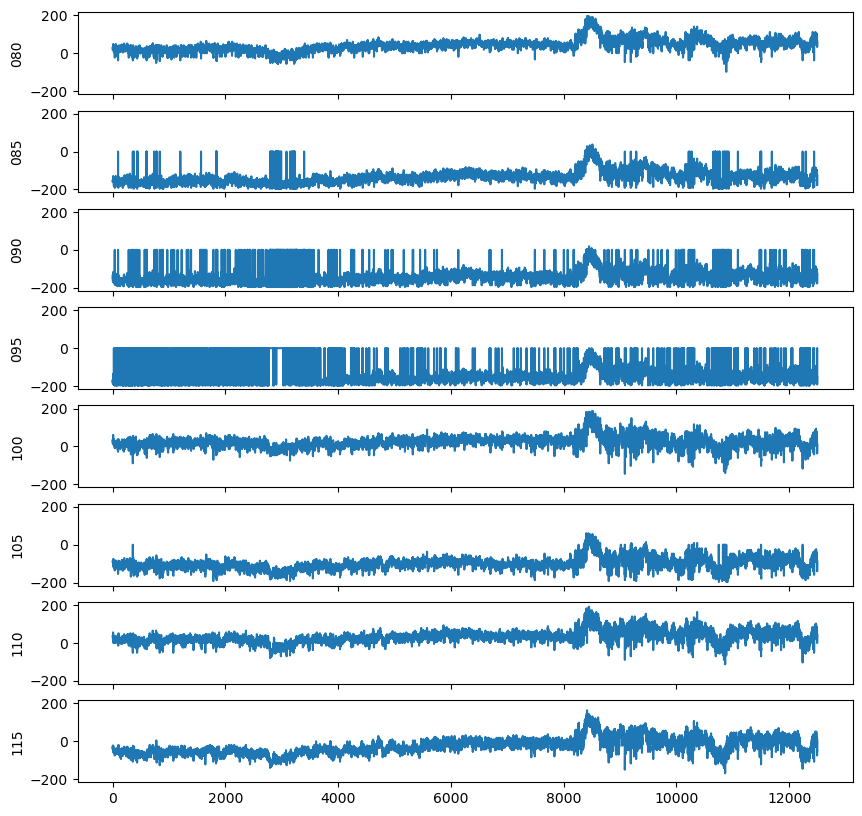

In [46]:
sample_interval = 5
fig, axes = plt.subplots(nrows=int(len(convData)/sample_interval),ncols=1,sharex=True, sharey=True, figsize = (10,10))
for i,chanid in enumerate(np.arange(0,len(convData),sample_interval)):
    axes[i].plot(convData[chanid][int(15*sRate):int(20*sRate)])
    axes[i].set_ylabel('%03d'%(chanid+80))
    # axes[i].set_xticks(np.arange(0,5,5)*sRate,np.arange(0,25,5))
plt.savefig('rawData_timeframe_lfp.png')

In [9]:
np.save('rawdata_grating_patch.npy',convData)

# preprocess data 
## Step1: filter signal

In [9]:
xf = filter_signal(selectData, sRate, 500, 1200)

In [13]:
np.save('filteredData_grating_patch.npy',xf)

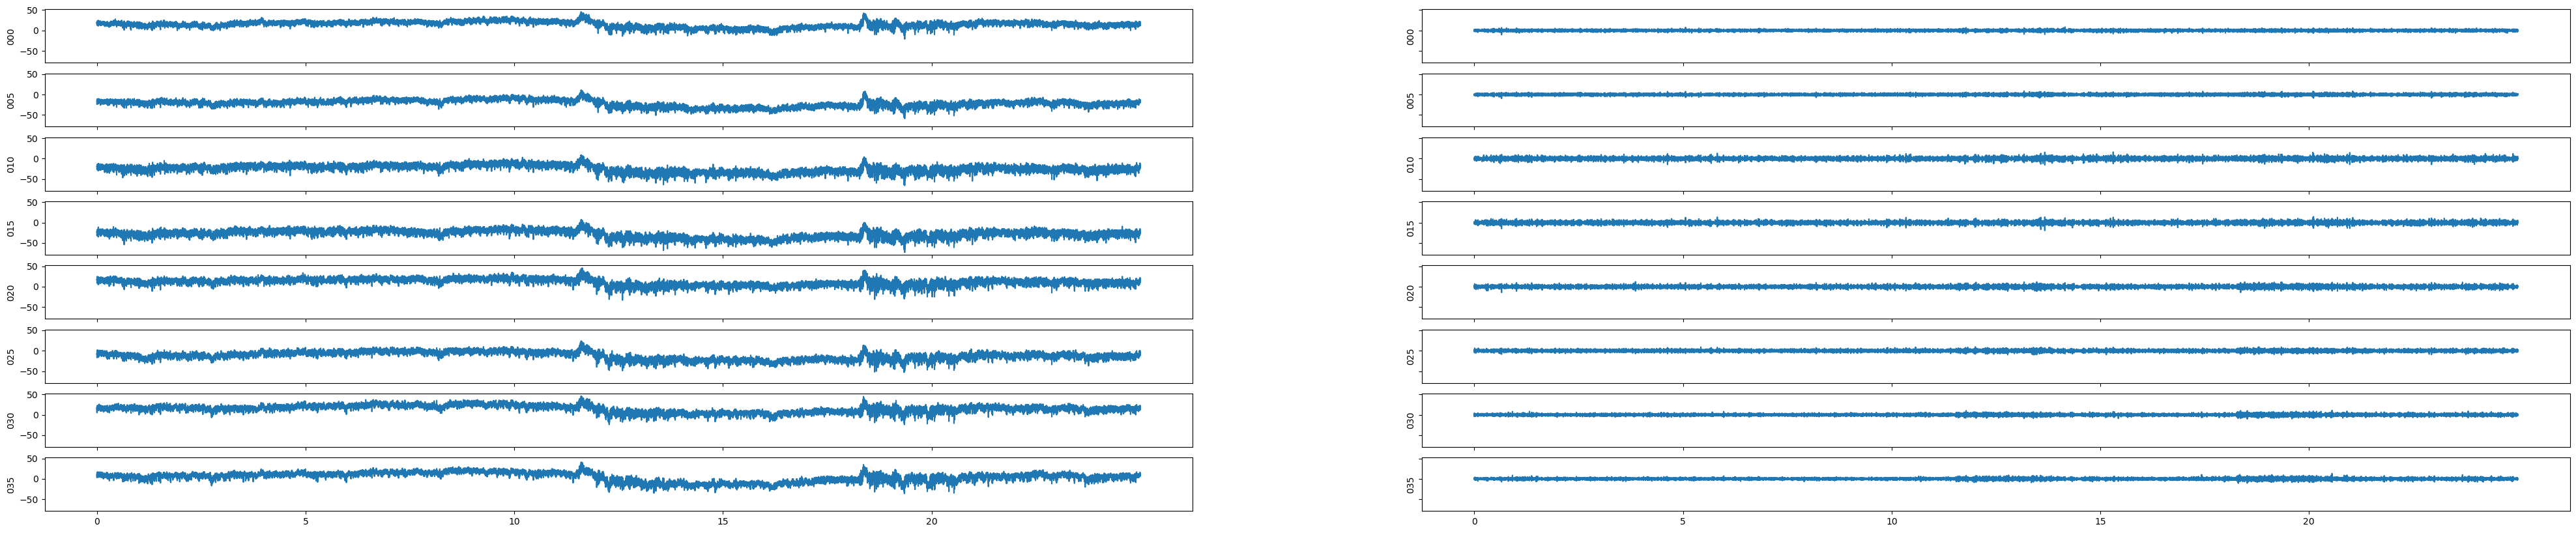

In [11]:
sample_interval = 5
fig, axes = plt.subplots(nrows=int(len(xf)/sample_interval),ncols=2,figsize = (50,10),sharex=True,sharey=True)
for i,chanid in enumerate(np.arange(0,len(xf),sample_interval)):
    axes[i,0].plot(selectData[chanid][:int(25*sRate)])
    axes[i,0].set_ylabel('%03d'%chanid)
    axes[i,0].set_xticks(np.arange(0,25,5)*sRate,np.arange(0,25,5))
    axes[i,1].plot(xf[chanid][:int(25*sRate)])
    axes[i,1].set_ylabel('%03d'%chanid)
    axes[i,1].set_xticks(np.arange(0,25,5)*sRate,np.arange(0,25,5))
#plt.savefig('filtered_Data_timeframe_uV.png')

## Step2: detect AP

In [12]:
from scipy import signal
from functools import reduce


In [4]:
xf = np.load('filteredData_grating_patch.npy',allow_pickle=True)

In [13]:
def app_refractory(x, last_x, lockout):
    if x-last_x > lockout:
        last_x = x
    return last_x 

In [14]:
def detect_spikes(x, fs, N=5, lockout=10):

    """Detect spikes, in this case, the relative local minima of the signal x.
    
    Parameters
    ----------
    
    x: pd.DataFrame
        The filtered signal from Task 1.
        
    fs: int
        the sampling rate (in Hz).
        
    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.
        
    lockout: int
        a window of 'refactory period', within which there's only one spike. 
        Default is 10 but you should also try changing it. 
    
    
    Returns
    -------
    
    s: np.array, (n_spikes,)
        Spike location / index in the singal x. 
    
    t: np.array, (n_spikes,)
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.
    
    thrd: float
        Threshold = -Nσ. 
        
    ----
    
    Use scipy functions to detect local minima. 
    Noted that there are four channels in signal x. 
        
    """

    # ---------------------------------
    # compute the robust s.d. 
    # ---------------------------------
    
    robustsd = np.median(np.abs(x-np.average(x))/0.6745)
    
    # --------------------------------
    # find all local minima 
    # --------------------------------
    
    lm_all = []

    for ch in range(len(x)):
        
        lm_ch = signal.find_peaks(-x[ch,:], distance = lockout)[0]
        lm_all.append(lm_ch)
    
    lm_all_clean = reduce(np.union1d, lm_all)

    
    # ---------------------------------
    # calculate the threshold 
    # ---------------------------------
    thrd = -N*robustsd
    ind_pass_thrd = np.where(np.min(x[:,lm_all_clean],axis=0)<thrd)[0]
    s_all = lm_all_clean[ind_pass_thrd]    
  
    if len(s_all)>0:
        ## delete duplicate detection from different channel
        last_lm = s_all[0]
        s_dup = np.ones(s_all.shape)*last_lm.astype(int)
        
        for i, stp in enumerate(s_all[1:]):
            s_dup[i+1] = app_refractory(stp, s_dup[i], lockout)
        s = np.unique(s_dup).astype(int)
        
        t = s/fs*1000
    else:
        s,t = [],[]
    

    return (s, t), thrd, s_all

In [32]:
(s, t), threshold, s_all = detect_spikes(xf, sRate, N=5)
print('from chan %03d to %03d: found %d spikes with th %.2f'%(chanList[0],chanList[-1],len(s_all),threshold))

from chan 080 to 119: found 24610 spikes with th -6.71


In [16]:
def plot_peaks(axs, time_series, data, fs, peak_times, thr):
    time_points = (time_series*fs).astype(int)
    peak_index = (peak_times*fs).astype(int)
    axs.plot(time_series, data[time_points],linewidth=.5)
    axs.scatter(peak_times, data[peak_index], c='red',s=10)
    axs.plot(np.ones_like(data)*thr, "--", color="gray")
    axs.plot(-1*np.ones_like(data)*thr, "--", color="gray")
    axs.set_xlim((time_series[0], time_series[-1]))
    # axs.set_ylabel('V')
    return axs

In [17]:
plt.close('all')

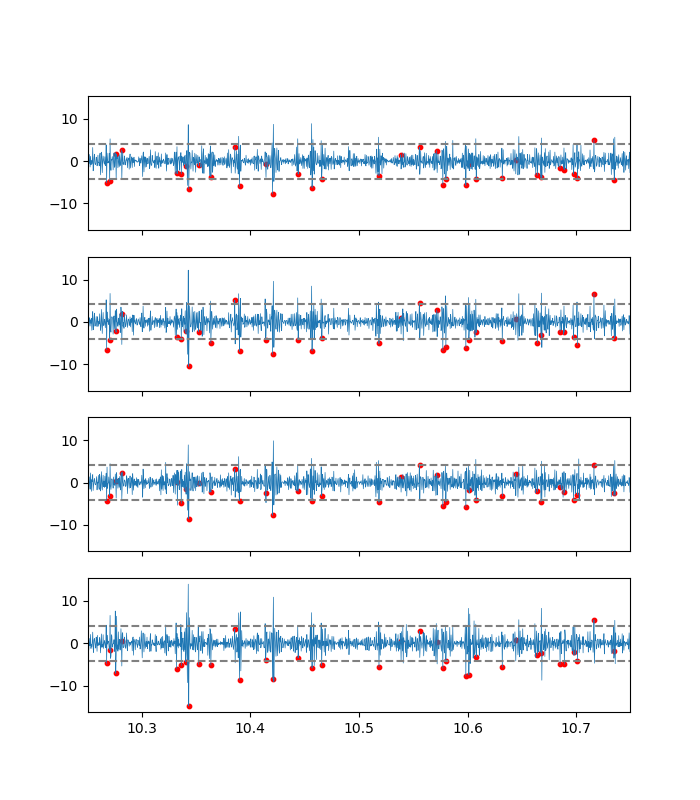

In [202]:
fig, axes = plt.subplots(nrows=4,ncols=1,sharey = True, sharex=True, figsize = (7,8))
start_time = 10.25
stop_time = 10.75
time_series = np.arange(start_time, stop_time, step=1/sRate)
%matplotlib widget
from ipywidgets import interact
(s, t), threshold, s_all = detect_spikes(xf[11:15], sRate, N=3, lockout=5)
peak_times = t[np.where((t<(stop_time*1000))&(t>(start_time*1000)))[0]]/1000
for i,chanid in enumerate(np.arange(11,15)):
    axes[i] = plot_peaks(axes[i], time_series,  xf[chanid], sRate, peak_times, threshold)

#plt.savefig('detected_spks_Data_timeframe_uV.png')

# normalize data 

In [40]:
spike_times = t
bin_size = 200  # milliseconds

# Calculate the number of bins required
time_range = spike_times.max() - spike_times.min()
num_bins = np.ceil(time_range / bin_size).astype(int)

# Create bins
bins = np.arange(spike_times.min(), spike_times.max() + bin_size, bin_size)

# Use numpy.histogram to count spikes in each bin
spike_counts, _ = np.histogram(spike_times, bins=bins)


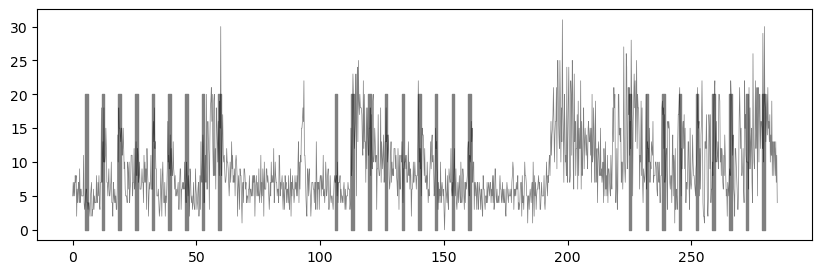

In [41]:
time_series = np.linspace(0,tEnd-tStart,len(spike_counts))
plt.figure(figsize=(10,3))
for i in range(len(tStimOnset)):
    plt.fill_betweenx([0,20], tStimOnset[i], tStimOffset[i], color="grey", alpha=1)
plt.plot(time_series, spike_counts,color='black',linewidth=.5,alpha=.5)

In [42]:
nSpk_ONset=np.zeros((len(tStimOnset),int(1000/bin_size)))
nSpk_OFFset=np.zeros((len(tStimOnset),int(1000/bin_size)))

for i in range(len(tStimOnset)):
    nSpk_ONset[i] = spike_counts[int(tStimOnset[i]*1000/bin_size):int(tStimOffset[i]*1000/bin_size)]
    nSpk_OFFset[i] = spike_counts[int((tStimOnset[i]-1)*1000/bin_size):int(tStimOnset[i]*1000/bin_size)]

In [43]:
nSpk_ONset_pos = nSpk_ONset.reshape(3,9,int(1000/bin_size))
nSpk_OFFset_pos = nSpk_OFFset.reshape(3,9,int(1000/bin_size))

In [44]:
normalized_Spk = np.sum(nSpk_ONset_pos.mean(axis=0) - nSpk_OFFset_pos.mean(axis=0),axis=1)

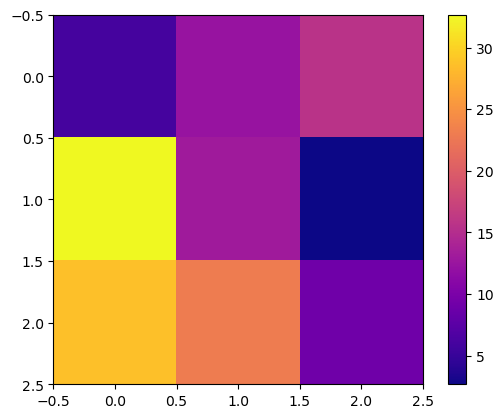

In [45]:
plt.figure()
plt.imshow(normalized_Spk.reshape(3,3).T,cmap='plasma') # tranpose because we first go through one column then second col 
plt.colorbar()
%matplotlib inline

In [46]:
import numpy as np
import matplotlib 
import matplotlib.colors as mcolors

# Example array of values
values = normalized_Spk.flatten()


# Normalize the values to the [0, 1] range
norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())

# Get the coolwarm colormap
coolwarm = matplotlib.colormaps.get_cmap('plasma')

# Apply the colormap to the normalized values
colors = coolwarm(norm(values))

# Each element in 'colors' now corresponds to an RGBA color for the given value
# print("RGBA colors:", colors)


In [150]:
time_axis_new = np.tile(time_axis,6).reshape(6, len(time_axis))

In [199]:
def plot_voltage_with_position(axs, time_axis, data_arr, average_data, fs, linecolor, offset=30):
    yoffset_mat = offset * np.arange(1,len(data_arr)+1)[:,np.newaxis] * np.ones((data_arr.shape[0],len(time_series)))
    data_arr = data_arr + yoffset_mat
    time_axis_new = np.tile(time_axis,data_arr.shape[0]).reshape(data_arr.shape[0], len(time_axis))
    data_arr[:,0:5] = np.nan
    time_axis_new[:,0:5] = np.nan
    axs.plot(time_axis_new.T, data_arr.T, linewidth=.2, c='black')
    axs.axvline(x=0,linestyle='--',c='lightgrey')
    axs.fill_betweenx([np.min(average_data),np.nanmax(data_arr)],0,1,color="lightgrey", alpha=.3)
    axs.plot(time_axis, average_data, linewidth=.2, c=linecolor)
    
    # Remove x and y ticks
    axs.set_xticks([])
    axs.set_yticks([])

    # Optional: Remove spines
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    
    return axs, data_arr


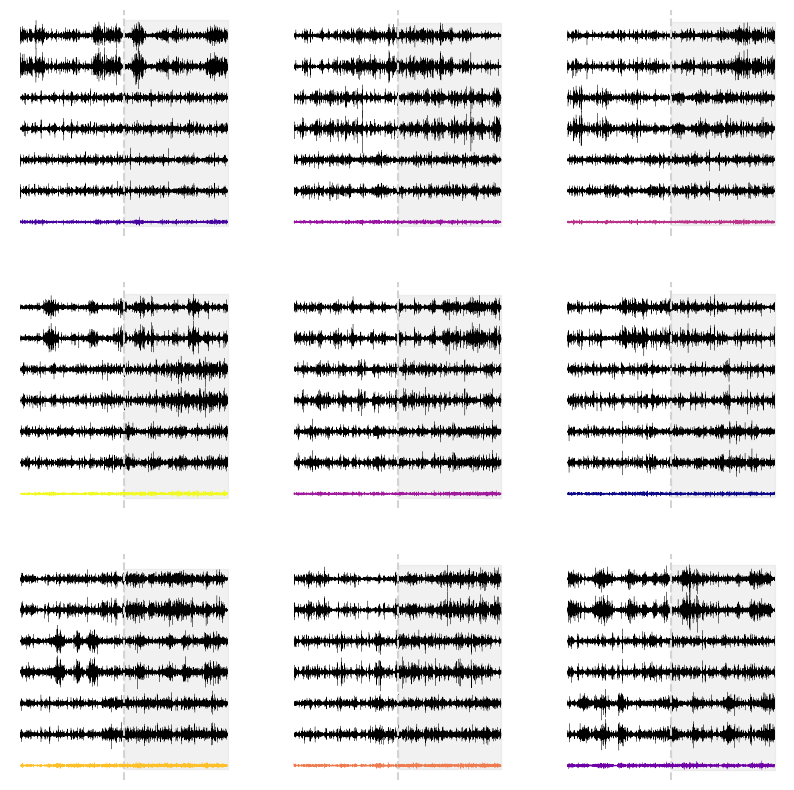

In [200]:
coi = find_middle_channels(0, len(xf), 2)
tStimOnset = tStimOnset.reshape((3,9))
tStimOffset = tStimOffset.reshape((3,9))
stim_duration = 1
time_axis = np.arange(-stim_duration,stim_duration,step=1/sRate)
fig, axes = plt.subplots(nrows=3,ncols=3,sharey = True, sharex=True, figsize = (10,10))
for i in range(tStimOnset.shape[1]):
    start_time = tStimOnset[:,i] - stim_duration
    stop_time = tStimOnset[:,i] + stim_duration
    vol_data = np.zeros((tStimOnset[:,i].shape[0], len(coi), time_axis.shape[0]))
    avg_data = np.zeros((tStimOnset[:,i].shape[0], time_axis.shape[0]))
    for j in range(tStimOnset[:,i].shape[0]):
        time_series = np.linspace(tStimOnset[j,i]-stim_duration, tStimOnset[j,i]+stim_duration, int(2*stim_duration*sRate), endpoint=True)
        vol_data[j,] = xf[coi][:,(time_series*sRate).astype(int)]
        avg_data[j,] = xf[:,(time_series*sRate).astype(int)].mean(axis=0)
    row, col = i%3,i//3
    vol_data = vol_data.reshape(tStimOnset[:,i].shape[0]*len(coi),len(time_series))
    avg_data = avg_data.mean(axis=0)
    axes[row,col],data_arr = plot_voltage_with_position(axes[row,col], time_axis, vol_data, avg_data, sRate, colors[i])
    
    

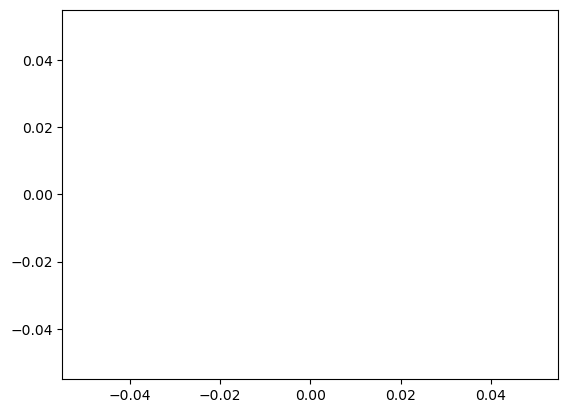

In [186]:
plt.plot(data_arr[:,0])

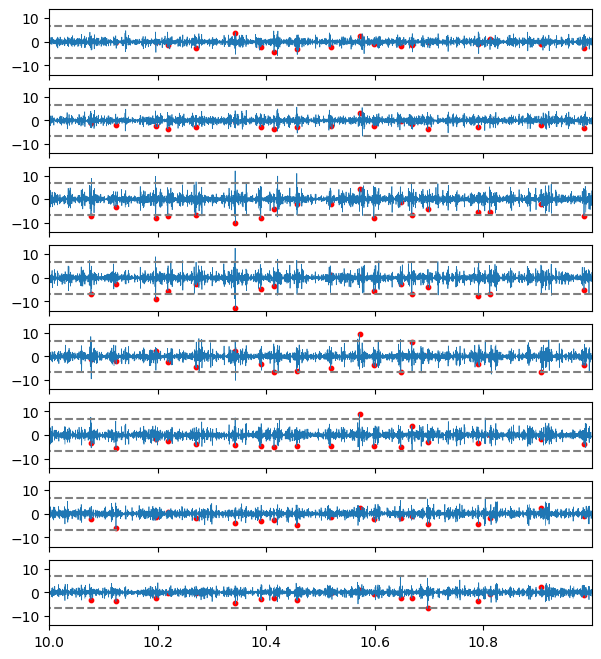

In [187]:
sample_interval = 5 
fig, axes = plt.subplots(nrows=int(len(xf)/sample_interval),ncols=1,sharey = True, sharex=True, figsize = (7,8))
start_time = 10
stop_time = 11
time_series = np.arange(start_time, stop_time, step=1/sRate)

(s, t), threshold, s_all = detect_spikes(xf, sRate, N=5,lockout=50)
peak_times = t[np.where((t<(stop_time*1000))&(t>(start_time*1000)))[0]]/1000
for i,chanid in enumerate(np.arange(0,40,sample_interval)):
    axes[i] = plot_peaks(axes[i], time_series,  xf[chanid], sRate, peak_times, threshold)

plt.savefig('detected_spks_Data_timeframe_uV.png')